In [1]:
!pip install ucimlrepo

In [8]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import random
from math import ceil,sqrt
import matplotlib.pyplot as plt
from typing import Optional

## Сборка данных

In [9]:
data = pd.read_csv("DATA (1).csv")
data['GRADE'] = data['GRADE'].apply(lambda x: 1 if x >= 4 else 0)
data = data.drop('STUDENT ID', axis=1)
X= data.drop('GRADE', axis=1)
y=data['GRADE']
print(X)
print(y)


     Student Age  Sex  Graduated high-school type  Scholarship type  \
0              2    2                           3                 3   
1              2    2                           3                 3   
2              2    2                           2                 3   
3              1    1                           1                 3   
4              2    2                           1                 3   
..           ...  ...                         ...               ...   
140            2    1                           2                 3   
141            1    1                           2                 4   
142            1    1                           1                 4   
143            2    1                           2                 4   
144            1    1                           1                 5   

     Additional work  Regular artistic or sports activity  \
0                  1                                    2   
1                  1     

In [10]:
#Проверка отсутствующих значений
data.isna().sum()

Student Age                                                          0
Sex                                                                  0
Graduated high-school type                                           0
Scholarship type                                                     0
Additional work                                                      0
Regular artistic or sports activity                                  0
Do you have a partner                                                0
Total salary if available                                            0
Transportation to the university                                     0
Accomodation type in Cyprus                                          0
Mother's education                                                   0
Father's education                                                   0
Number of sisters/brothers                                           0
Parental status                                                      0
Mother

## Визуализация

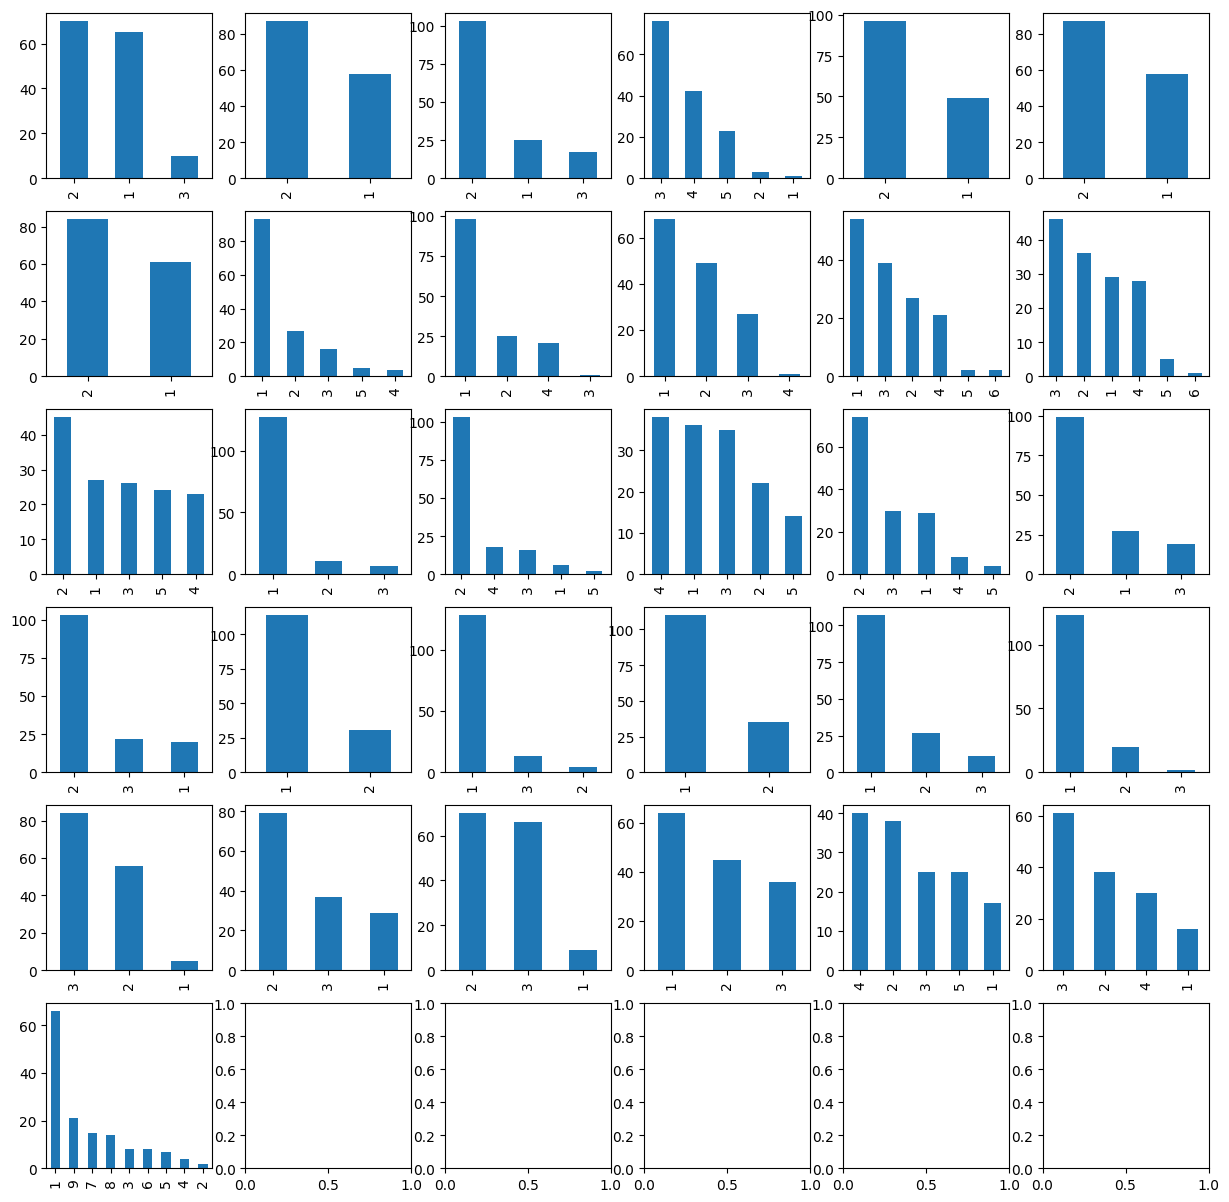

In [11]:
fig, axs = plt.subplots(ceil(sqrt(len(X.columns))), ceil(sqrt(len(X.columns))))
for ax, col in zip(axs.flatten(), X.columns):
    X[col].value_counts().plot(kind="bar", ax=ax)
fig.set_figheight(15)
fig.set_figwidth(15)

<Axes: >

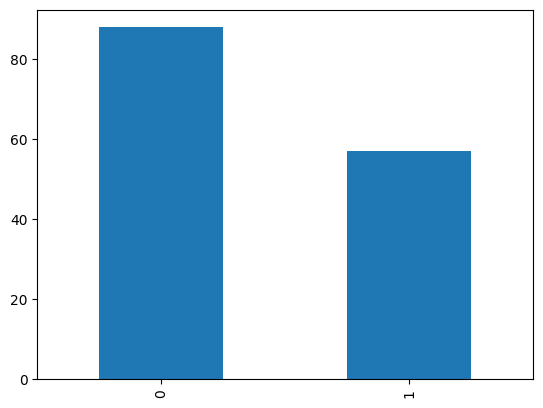

In [12]:
y.value_counts().plot(kind="bar")

## Decision Tree

In [13]:
class Node:
    def __init__(
        self,
        feature_name: str,
        value_to_node: dict[str, 'Node']
    ):
        self.feature_name = feature_name
        self.value_to_node = value_to_node

    def pred(self, x):
        feature_value = x[self.feature_name]
        if feature_value not in self.value_to_node:
            return None
        return self.value_to_node[feature_value].pred(x)

    def pred_prob(self, x):
        feature_value = x[self.feature_name]
        if feature_value not in self.value_to_node:
            return 0
        return self.value_to_node[feature_value].pred_prob(x)

    def print_node(self, indent=0):
        for value, node in self.value_to_node.items():
            print(' ' * indent + f'{self.feature_name} == {value}:')
            node.print_node(indent+2)

class LeafNode(Node):
    def __init__(
        self,
        leaf_value: str,
        prob: float
    ):
        super().__init__("", {})
        self.leaf_value = leaf_value
        self.prob = prob

    def pred(self, x):
        return self.leaf_value

    def pred_prob(self, x):
        return (self.leaf_value, self.prob)

    def print_node(self, indent=0):
        print(' ' * indent + f'-> {self.leaf_value} ({self.prob})')

class DecisionTree:
    def __init__(self, cols: list[str]):
        self.cols = cols

    def fit(self, x, y):
        self.root = self._build_node(x[self.cols], y, DecisionTree._entropy(y))

    def pred(self, x):
        res = []
        for row in x[self.cols].to_records():
            res.append(self.root.pred(row))
        return res

    def pred_prob(self, x):
        res = []
        for row in x[self.cols].to_records():
            res.append(self.root.pred_prob(row))
        return res

    def _build_node(self, x, y, parent_info: float) -> Node:
        if len(y.unique()) == 1:
            return LeafNode(y.unique()[0], 1)

        best_gain = 0
        best_gain_info = 0
        best_gain_col = ''

        for col in self.cols:
            cat_names = x[col].unique()
            info = 0

            for cat in cat_names:
                cat_weight = x[col].value_counts()[cat] / len(x)
                entropy = DecisionTree._entropy(y[x[col] == cat])
                info += cat_weight * entropy

            if parent_info - info > best_gain:
                best_gain = parent_info - info
                best_gain_info = info
                best_gain_col = col

        if best_gain_col == '':
            mode = y.mode()[0]
            return LeafNode(mode, y.value_counts()[mode] / len(y))

        values_to_node = {}

        cat_names = x[best_gain_col].unique()
        for cat in cat_names:
            values_to_node[cat] = self._build_node(x[x[best_gain_col] == cat], y[x[best_gain_col] == cat], best_gain_info)

        return Node(best_gain_col, values_to_node)

    def print_tree(self):
        self.root.print_node()

    @staticmethod
    def _entropy(y) -> float:
        cls_names = y.unique()
        res = 0

        for cls in cls_names:
            cls_prob = y.value_counts()[cls] / len(y)
            res -= cls_prob * log2(cls_prob)

        return res


## Train-Test-Split

In [14]:
samples_amount = 0.3
random_state = 336771

test_x = X.sample(frac=samples_amount, random_state=random_state)
test_y = y[test_x.index]
train_x = X.drop(test_x.index, axis=0)
train_y = y[train_x.index]

## Training

In [15]:
cols = X.columns
cols = np.random.choice(cols, ceil(sqrt(len(cols))))

print("Используются признаки:", *cols)

tree = DecisionTree(cols)
tree.fit(train_x, train_y)
tree.print_tree()

Используются признаки: Discussion improves my interest and success in the course Do you have a partner Scholarship type COURSE ID Flip-classroom Attendance to the seminars/conferences related to the department
COURSE ID == 1:
  -> 0 (0.7708333333333334)
COURSE ID == 2:
  Discussion improves my interest and success in the course == 2:
    -> 1 (1)
  Discussion improves my interest and success in the course == 1:
    -> 0 (1)
COURSE ID == 3:
  -> 1 (1)
COURSE ID == 4:
  Discussion improves my interest and success in the course == 2:
    -> 1 (1)
  Discussion improves my interest and success in the course == 3:
    -> 0 (1)
COURSE ID == 5:
  Discussion improves my interest and success in the course == 1:
    -> 1 (1)
  Discussion improves my interest and success in the course == 2:
    -> 0 (1)
  Discussion improves my interest and success in the course == 3:
    -> 1 (1)
COURSE ID == 6:
  -> 1 (1)
COURSE ID == 7:
  Scholarship type == 5:
    -> 1 (1)
  Scholarship type == 4:
    -> 1 (1)

## Testing

### Metrics
Мы будем использовать E как положительный признак, P - как отрицательный

In [16]:
def confusion_matrix(pred_y, true_y):
    res = np.zeros((2, 2))

    for pred, true in zip(pred_y, true_y):
        pred = 1 if pred == 1 else 0
        true = 1 if true == 1 else 0
        res[pred][true] += 1

    return res

def confusion_matrix_prob(pred_probs, true_y, threshold):
    res = np.zeros((2, 2))

    for pred_prob, true in zip(pred_probs, true_y):
        pred = 1 if pred_prob >= threshold else 0
        true = 1 if true == 1 else 0
        res[pred][true] += 1

    return res

def accuracy(conf):
    return (conf[1][1] + conf[0][0]) / sum(conf.flatten())

def precision(conf):
    return conf[1][1] / (conf[1][1] + conf[1][0])

def recall(conf):
    return conf[1][1] / (conf[1][1] + conf[0][1])

def fallout(conf):
    return conf[1][0] / (conf[1][0] + conf[0][0])


In [17]:
pred_y = tree.pred(test_x)
conf = confusion_matrix(pred_y, test_y)
print(conf)
print('Accuracy:', accuracy(conf))
print('Precision', precision(conf))
print('Recall:', recall(conf))

[[29.  5.]
 [ 0. 10.]]
Accuracy: 0.8863636363636364
Precision 1.0
Recall: 0.6666666666666666


## AUC
Для ROC и PR

In [19]:
pred_prob = tree.pred_prob(test_x)
probs = []

for i in range(len(pred_prob)):
    pred, prob = pred_prob[i]
    if pred == 1:
        probs.append(prob)
    else:
        probs.append(1-prob)

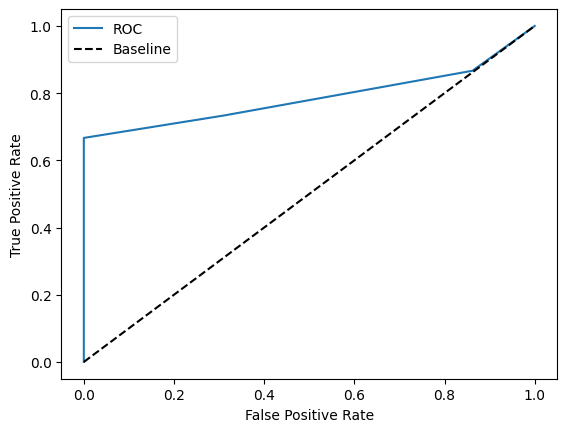

In [20]:
tpr = []
fpr = []

for th in np.arange(1, 0, -0.01):
    conf = confusion_matrix_prob(probs, test_y, th)
    tpr.append(recall(conf))
    fpr.append(fallout(conf))

plt.plot([0] + fpr + [1], [0] + tpr + [1], label='ROC')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), 'k--', label='Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

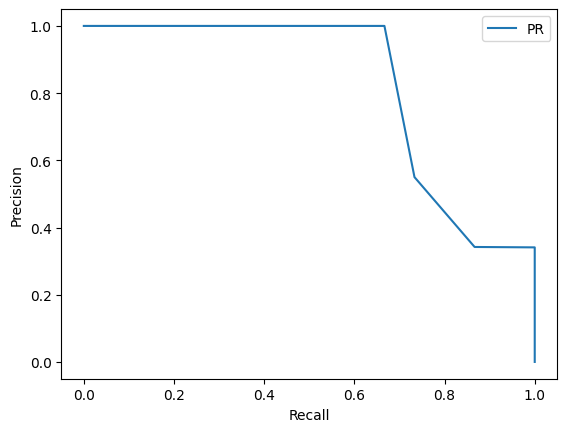

In [21]:
p = []
r = []

for th in np.arange(0, 1, 0.01):
    conf = confusion_matrix_prob(probs, test_y, th)
    p.append(precision(conf))
    r.append(recall(conf))

plt.plot([1] + r + [0], [0] + p + [1], label='PR')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()